In [9]:
import cv2
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import AppLayout, Button, Layout, HTML
from IPython.display import display, Image

%matplotlib inline

In [3]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [4]:
train_txt = Path("/home/alexsh/darknet_experiments/src/darknet_train_helper/c_trailers.txt")

with open(train_txt, "r") as f:
    txt_guts = f.read().splitlines()

new_txt_guts = [train_txt.parents[2] / i for i in txt_guts]
annotations = [Path(img).with_suffix('.txt') for img in new_txt_guts]
data_tuples = list(zip(new_txt_guts,annotations))

df = pd.DataFrame(data_tuples, columns=["imgs", "annotations"])

In [10]:
def to_cv_coords(img, rect):
    height, width, _ = img.shape
    x = float(rect[1]) * width
    y = float(rect[2]) * height
    w = float(rect[3]) * width
    h = float(rect[4]) * height
    
    x1, y1 = x-w/2, y-h/2
    x2, y2 = x+w/2, y+h/2
    
    return int(x1), int(y1), int(x2), int(y2)


def plot_img(img_path):
    input_img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)

    txt_path = Path(img_path).with_suffix('.txt')

    with open(str(txt_path), "r") as f:
        lines = f.read().splitlines()

    dn_coords = [line.split() for line in lines]

    for i in range(len(dn_coords)):
        x1, y1, x2, y2 = to_cv_coords(input_img, dn_coords[i])
        cv2.rectangle(input_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    #success, encoded_image = cv2.imencode('.jpg', input_img)
    plt.imshow(input_img)
    plt.show()
    
    #return encoded_image.tobytes()


class Loop():
    def __init__(self, values):
        self._values = values
        self._max_idx = len(values) - 1
        self._current_idx = 0
    
    def next(self):
        if self._current_idx == self._max_idx:
            self._current_idx = 0
        else:
            self._current_idx += 1
        return self._values[self._current_idx]
    
    def previous(self):
        if self._current_idx == 0:
            self._current_idx = self._max_idx
        else:
            self._current_idx -= 1
        return self._values[self._current_idx]
    
    def __repr__(self):
        return f"Loop({self._values})"


def annotaions_viwer(df):
    imgs = df["imgs"]
    anns = df["annotations"]

    images = Loop(imgs)

    image_container = plot_img(str(imgs[0]))
    image_widget = widgets.Image(value=image_container,
                                format="jpg",
                                width="100%",
                                height="100%"
                                )

    header = widgets.HTML("<h1><center><p><strong>Image Viewer</strong></p></center></h1>", 
                          layout=Layout(height="auto")
                          )
                          
    footer = widgets.HTML(f"{str(imgs[0])}", layout=Layout(height="auto"))

    next_button = Button(description="Next",
                        icon="forward",
                        layout=Layout(width="80%", height="30%")
                        )

    prev_button = Button(description="Prev", 
                        icon="backward", 
                        layout=Layout(width="80%", height="30%")
                        )

    def update_image(filename: str):
        image_widget.value = plot_img(str(filename))
        
        
    def update_footer(filename: str):
        footer.value = f"{filename}"

        
    def update_widgets(filename: str):
        update_image(filename)
        update_footer(filename)
        
        
    def handle_next(b):
        update_widgets(images.next())
        
        
    def handle_prev(b):
        update_widgets(images.previous())


    prev_button.on_click(handle_next)
    next_button.on_click(handle_prev) 

    app = AppLayout(header=header,
            left_sidebar=prev_button,
            center=image_widget,
            right_sidebar=next_button,
            footer=footer,
            grid_gap='30px',
            justify_items='center',
            align_items='center')
    
    return app

In [5]:
annotaions_viwer(df)

AppLayout(children=(HTML(value='<h1><center><p><strong>Image Viewer</strong></p></center></h1>', layout=Layout…

In [17]:
imgs = df["imgs"]

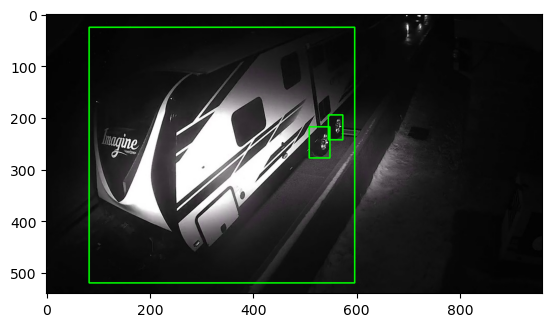

In [18]:
plot_img(str(imgs[133]))